In [2]:
# Fundamental classes
import numpy as np 
import pandas as pd 
import tensorflow as tf
import os
import random
# Image related
import cv2
from PIL import Image

#Performance Plot
from sklearn import metrics 
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# For the model and it's training
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
cur_path = os.getcwd()
path = os.path.join(cur_path, 'resized')
print(path)

c:\Users\Acer\repos\CNN-Practices\artists-artworks\resized


In [4]:
artists = pd.read_csv("artists.csv")
print(artists.shape)

(50, 8)


In [5]:
artists = artists.sort_values(by=['paintings'], ascending=False)
artists_top = artists[['name', 'genre', 'paintings']]
artists_top['class_weight'] = dict(1 / artists_top['paintings'])
print(artists_top.head(20))


                     name                                    genre  paintings   
8        Vincent van Gogh                       Post-Impressionism        877  \
30            Edgar Degas                            Impressionism        702   
13          Pablo Picasso                                   Cubism        439   
15  Pierre-Auguste Renoir                            Impressionism        336   
19         Albrecht Dürer                     Northern Renaissance        328   
46           Paul Gauguin             Symbolism,Post-Impressionism        311   
16         Francisco Goya                              Romanticism        291   
31              Rembrandt                                  Baroque        262   
20          Alfred Sisley                            Impressionism        259   
32                 Titian               High Renaissance,Mannerism        255   
22           Marc Chagall                              Primitivism        239   
4           Rene Magritte   

C:\Users\Acer\AppData\Local\Temp\ipykernel_14348\4258776037.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  artists_top['class_weight'] = dict(1 / artists_top['paintings'])


c:\Users\Acer\repos\CNN-Practices\artists-artworks\resized\Alfred_Sisley_113.jpg
c:\Users\Acer\repos\CNN-Practices\artists-artworks\resized\Edouard_Manet_0_5684.jpg
c:\Users\Acer\repos\CNN-Practices\artists-artworks\resized\Edvard_Munch_0_8425.jpg
c:\Users\Acer\repos\CNN-Practices\artists-artworks\resized\Gustave_Courbet_49.jpg
c:\Users\Acer\repos\CNN-Practices\artists-artworks\resized\Francisco_Goya_138.jpg


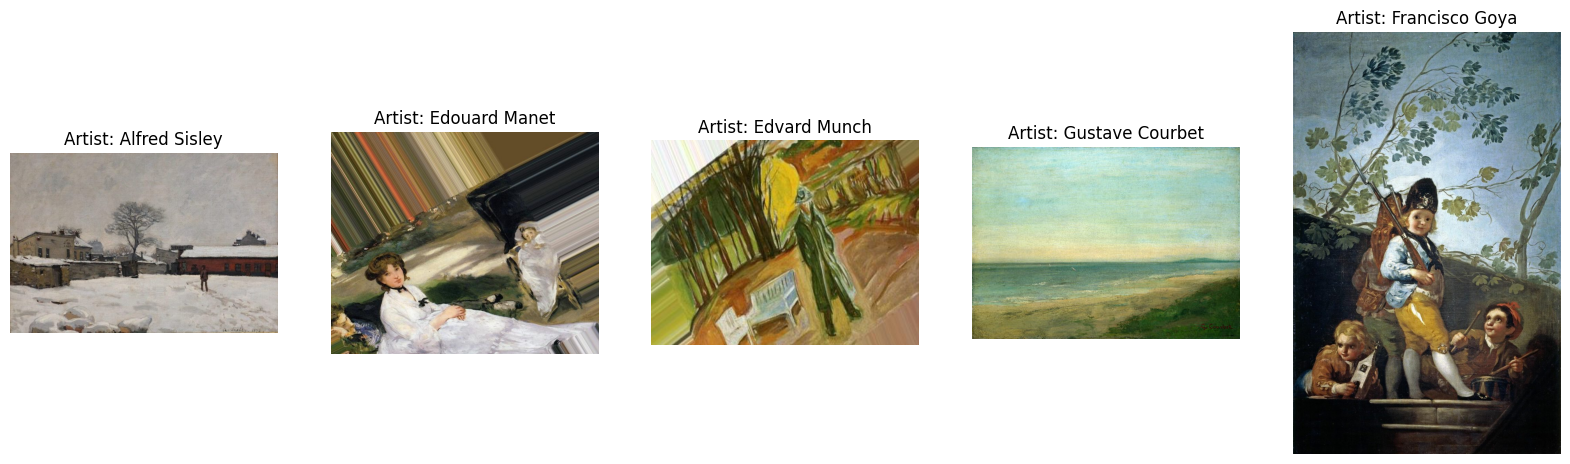

In [6]:
artists_top_name = artists_top['name'].str.replace(' ', '_').values

# Print few random paintings
n = 5
fig, axes = plt.subplots(1, n, figsize=(20,10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice([f for f in os.listdir(path) if f.startswith(random_artist)])
    random_image_file = os.path.join(path, random_image)
    print(random_image_file)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')

plt.show()

In [7]:
# Artists with more than 250 paintings
more_than_250 = artists[artists['paintings'] > 250]
print(more_than_250)
# Artists with fewer than 250 paintings
fewer_than_250 = artists[artists['paintings'] <= 250]


    id                   name        years                         genre   
8    8       Vincent van Gogh  1853 – 1890            Post-Impressionism  \
30  30            Edgar Degas  1834 - 1917                 Impressionism   
13  13          Pablo Picasso  1881 - 1973                        Cubism   
15  15  Pierre-Auguste Renoir  1841 - 1919                 Impressionism   
19  19         Albrecht Dürer  1471 - 1528          Northern Renaissance   
46  46           Paul Gauguin  1848 – 1903  Symbolism,Post-Impressionism   
16  16         Francisco Goya  1746 - 1828                   Romanticism   
31  31              Rembrandt  1606 - 1669                       Baroque   
20  20          Alfred Sisley  1839 - 1899                 Impressionism   
32  32                 Titian  1488 - 1576    High Renaissance,Mannerism   

       nationality                                                bio   
8            Dutch  Vincent Willem van Gogh (Dutch: [ˈvɪnsɛnt ˈʋɪl...  \
30          Frenc

In [8]:
for artist in more_than_250['name'].str.replace(' ', '_').values:
    artist_files = [f for f in os.listdir(path) if f.startswith(artist)]
    if len(artist_files) > 250:
        random_files = random.sample(artist_files, len(artist_files) - 250)
        for f in random_files:
            os.remove(os.path.join(path, f))
 

In [12]:
# apply data augmentation for artists with fewer than 250 paintings
datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    zoom_range=0.3,
    fill_mode='nearest',
    shear_range=0.3
)

for artist in fewer_than_250['name'].str.replace(' ', '_').values:
    artist_files = [f for f in os.listdir(path) if f.startswith(artist)]
    num_augmented_images = 250 - len(artist_files)
    
    # Randomly select images for augmentation
    selected_images = random.choices(artist_files, k=num_augmented_images)
    
    # Apply augmentation to the selected images
    for f in selected_images:
        img = cv2.imread(os.path.join(path, f))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.reshape((1,) + img.shape)
        
        # generate only one augmented image for the current image
        i = 0
        for batch in datagen.flow(img, batch_size=1, save_to_dir=path, save_prefix=artist, save_format='jpg'):
            i += 1
            if i > 0:
                break
            
        

In [7]:
# let's check the number of paintings for each artist
paintings = []

for artist in artists_top_name:
    paintings.append(len([f for f in os.listdir(path) if f.startswith(artist)]))

artists_top['paintings'] = paintings
print(artists_top.head(20))

                     name                                    genre  paintings   
8        Vincent van Gogh                       Post-Impressionism        250  \
30            Edgar Degas                            Impressionism        250   
13          Pablo Picasso                                   Cubism        250   
15  Pierre-Auguste Renoir                            Impressionism        250   
19         Albrecht Dürer                     Northern Renaissance          0   
46           Paul Gauguin             Symbolism,Post-Impressionism        250   
16         Francisco Goya                              Romanticism        250   
31              Rembrandt                                  Baroque        250   
20          Alfred Sisley                            Impressionism        250   
32                 Titian               High Renaissance,Mannerism        250   
22           Marc Chagall                              Primitivism        250   
4           Rene Magritte   

C:\Users\Acer\AppData\Local\Temp\ipykernel_14348\1488080341.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  artists_top['paintings'] = paintings


In [8]:
# Split the data into training and testing sets
X = []
y = []

for artist in artists_top_name:
    for f in os.listdir(path):
        if f.startswith(artist):
            img = cv2.imread(os.path.join(path, f))
            img = cv2.resize(img, (224, 224))
            X.append(img)
            y.append(artist)

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [9]:
# let's check the shape of the training and testing sets
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(9765, 224, 224, 3) (2442, 224, 224, 3)
(9765,) (2442,)


In [10]:
# One-hot encode the labels
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

In [11]:
# load the pre-trained model resnet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# freeze the layers in the base model  
for layer in base_model.layers:
    layer.trainable = False

In [12]:
# Add layers at the end
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(49, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

In [13]:
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [14]:
n_epoch = 10

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [15]:
# Train the model - all layers

history = model.fit(X_train, y_train, batch_size=32, epochs=n_epoch, validation_data=(X_test, y_test), callbacks=[early_stop, reduce_lr])


Epoch 1/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 486s 2s/step - accuracy: 0.1343 - loss: 3.5880 - val_accuracy: 0.2952 - val_loss: 3.1806 - learning_rate: 1.0000e-04
Epoch 2/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 472s 2s/step - accuracy: 0.5065 - loss: 2.8922 - val_accuracy: 0.3665 - val_loss: 3.1733 - learning_rate: 1.0000e-04
Epoch 3/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 472s 2s/step - accuracy: 0.7110 - loss: 2.5534 - val_accuracy: 0.4058 - val_loss: 3.0867 - learning_rate: 1.0000e-04
Epoch 4/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 471s 2s/step - accuracy: 0.8130 - loss: 2.2818 - val_accuracy: 0.4214 - val_loss: 3.0239 - learning_rate: 1.0000e-04
Epoch 5/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 471s 2s/step - accuracy: 0.8669 - loss: 2.0385 - val_accuracy: 0.4525 - val_loss: 2.9273 - learning_rate: 1.0000e-04
Epoch 6/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 469s 2s/step - accuracy: 0.8981 - loss: 1.8243 - val_accuracy: 0.4709 - val_loss: 2.8565 - learning_rate: 1.0000e-04
Epoch 7/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 471s 2s/step - acc

77/77 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step
Accuracy: 0.5151515151515151
F1 Score: 0.5059822947174497
              precision    recall  f1-score   support

           0       0.58      0.75      0.65        40
           1       0.75      0.71      0.73        51
           2       0.45      0.63      0.52        46
           3       0.47      0.69      0.56        49
           4       0.25      0.37      0.30        35
           5       0.39      0.62      0.48        50
           6       0.43      0.59      0.50        46
           7       0.45      0.53      0.49        53
           8       0.51      0.50      0.51        44
           9       0.78      0.33      0.46        55
          10       0.22      0.26      0.24        47
          11       0.64      0.39      0.49        64
          12       0.70      0.50      0.58        62
          13       1.00      0.24      0.39        49
          14       1.00      0.11      0.20        53
          15       0.49      0.63     

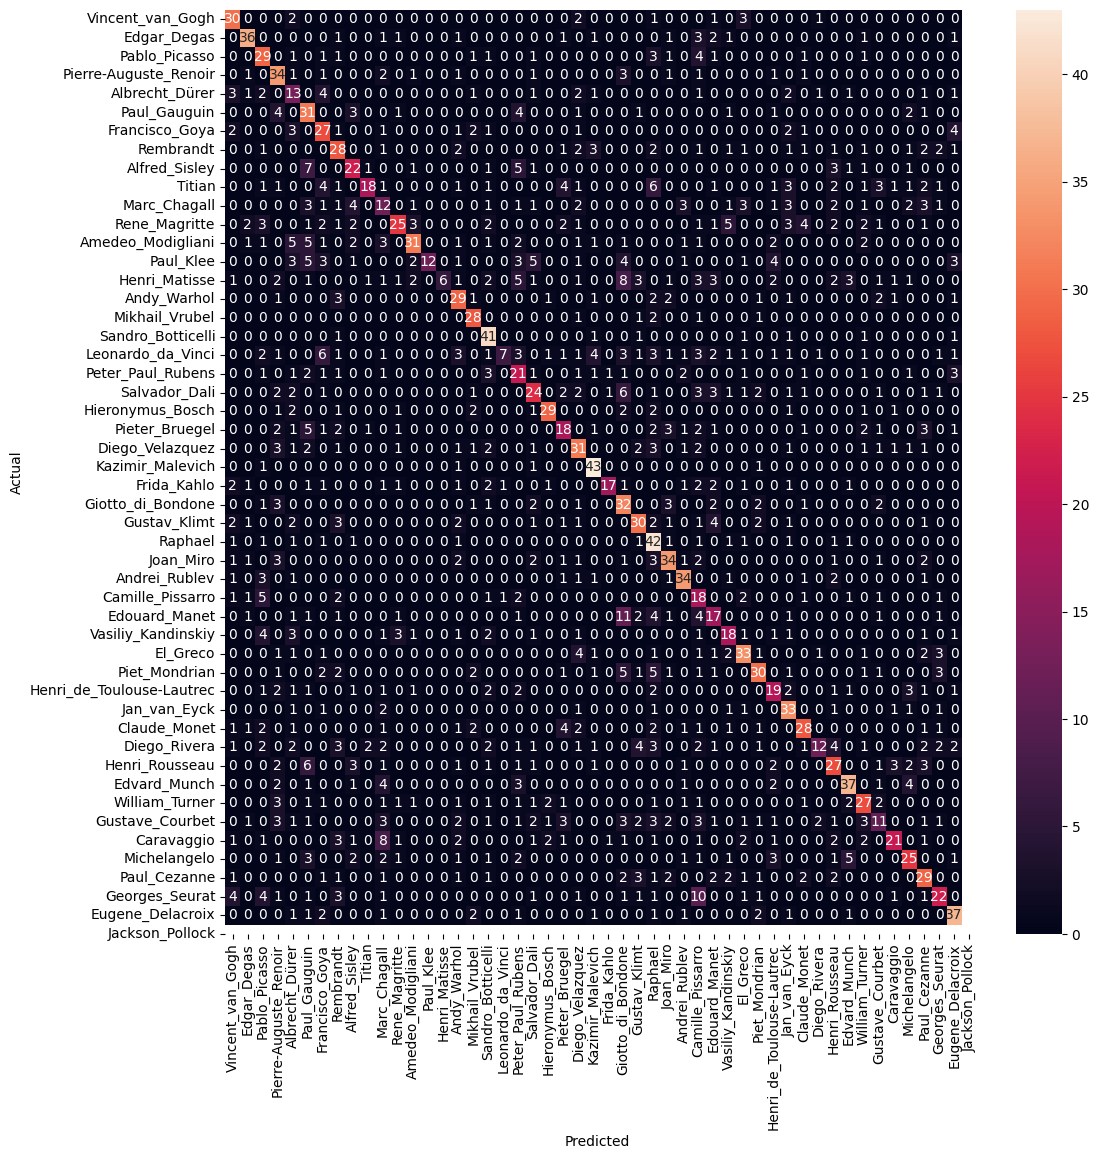

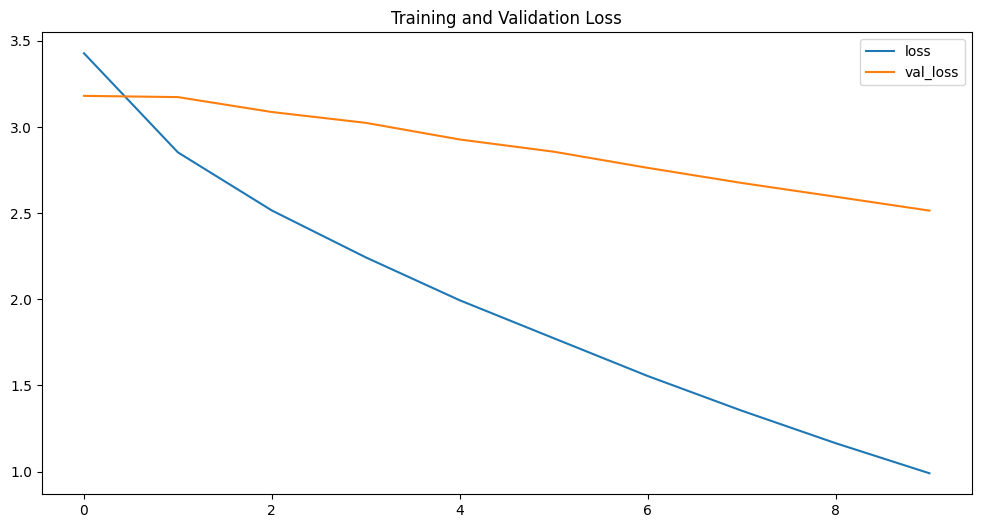

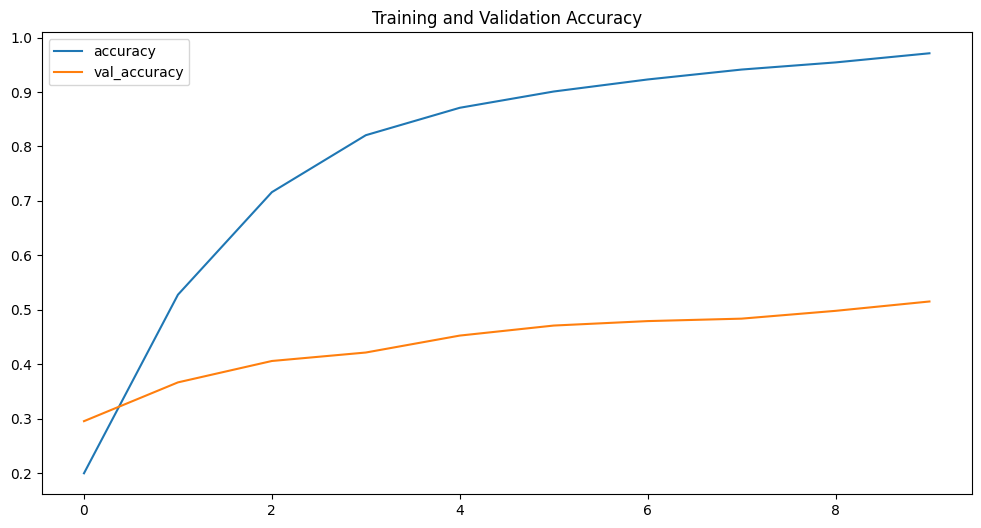

In [16]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print('Accuracy:', accuracy)
print('F1 Score:', f1)

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=artists_top_name, yticklabels=artists_top_name)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


In [22]:
# save the model
model.save('artist_classifier.h5')